In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

plt.ion()  
use_gpu = torch.cuda.is_available()

if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
# Utility functions

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [3]:
def load_resnet():
    # Load the pretrained model from pytorch
    resnet50 = models.resnet50(pretrained=True)
    
    # Freeze training for all layers
    for param in resnet50.parameters():
        param.require_grad = False

    # Newly created modules have require_grad=True by default
    resnet50.fc = nn.Sequential(
                   nn.Linear(2048, 1024),
                   nn.ReLU(inplace=True),
                   nn.Dropout(),
                   nn.Linear(1024, 512),
                   nn.ReLU(inplace=True),
                   nn.Dropout(),
                   nn.Linear(512, 256),
                   nn.ReLU(inplace=True),
                   nn.Dropout(),
                   nn.Linear(256, 128),
                   nn.ReLU(inplace=True),
                   nn.Dropout(),
                   nn.Linear(128, 3))
    return resnet50

resnet50 = load_resnet()
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

)


In [4]:
data_dir = './car_data/data3a'
TRAIN = 'training'
VAL = 'validation'

# resnet Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(20, translate=(0.2, 0.2), scale=(0.9, 1.2)),
        transforms.ColorJitter(brightness=.2,hue=.2, saturation=.2),
        transforms.RandomPerspective(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor()
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}

for x in [TRAIN, VAL]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(class_names)

Loaded 1594 images under training
Loaded 181 images under validation
Classes: 
['01-minor', '02-moderate', '03-severe']


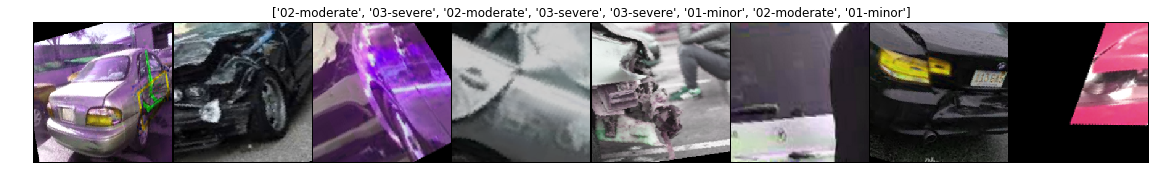

In [5]:
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

# print(inputs) [0.4122, 0.4125, 0.4286]
# print(inputs.mean(dim=0).mean(dim=1).mean(dim=1))

In [6]:
def train_model(resnet, criterion, optimizer, num_epochs=10):
    torch.cuda.empty_cache()
    since = time.time()
    best_model_wts = copy.deepcopy(resnet.cpu().state_dict())
    if use_gpu:
        resnet.cuda()
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    lowered1 = False
    lowered2 = False
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        resnet.train(True)
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
               
            optimizer.zero_grad() 
            outputs = resnet(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()               
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
        print()

        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train.item() / dataset_sizes[TRAIN]
        
        resnet.train(False)
        resnet.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            with torch.no_grad():
                if i % 10 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                inputs, labels = data


                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = resnet(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.item()
                acc_val += torch.sum(preds == labels.data)
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val.item() / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.5f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print("memory usage: {:4f}".format(torch.cuda.memory_allocated()/1e8))
        print()
        # adjust lr:
        if avg_acc_val> 0.70 and not lowered1:
            print("Lowering LR1")
            lowered1 = True
            for g in optimizer.param_groups:
                g['lr'] = 0.001

        if avg_acc_val> 0.78 and not lowered2:
            lowered2 = True
            print("Lowering LR2")
            for g in optimizer.param_groups:
                g['lr'] = 0.0001
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(resnet.cpu().state_dict())
            if use_gpu:
                resnet.cuda()
        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    resnet.load_state_dict(best_model_wts)
    return resnet

In [7]:
if use_gpu:
    resnet50.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet50.parameters(), lr=0.005, momentum=0.9, weight_decay=0.001)

In [8]:
resnet50 = train_model(resnet50, criterion, optimizer, num_epochs=1)

Epoch 0/1
----------
Training batch 190/200
Validation batch 20/23
Epoch 0 result: 
Avg loss (train): 0.1381
Avg acc (train): 0.3312
Avg loss (val): 0.13836
Avg acc (val): 0.3867
----------
memory usage: 3.267476


Training completed in 1m 18s
Best acc: 0.3867


In [9]:
# TODO: compose a test batch 

def eval_model(resnet, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[VAL])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[VAL]):
        with torch.no_grad():
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

            resnet.train(False)
            resnet.eval()
            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = resnet(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.item()
            acc_test += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
    
    print(acc_test)
    avg_loss = loss_test / dataset_sizes[VAL]
    avg_acc = acc_test.item() / dataset_sizes[VAL]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [10]:
# torch.save(resnet50.state_dict(), './gdrive/My Drive/Colab/Res_severity_newdata')

In [11]:
eval_model(resnet50, criterion)

Evaluating model
----------
Test batch 22/23tensor(70, device='cuda:0')

Evaluation completed in 0m 5s
Avg loss (test): 0.1384
Avg acc (test): 0.3867
----------


In [12]:
def visualize_model(resnet, num_images=6):
    # Set model for evaluation
    resnet.train(False)
    resnet.eval() 
    
    images_so_far = 0
    with torch.no_grad():
        for i, data in enumerate(dataloaders[VAL]):
            inputs, labels = data
            size = inputs.size()[0]

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = resnet(inputs)

            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]

            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)

            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()

            images_so_far += size
            if images_so_far >= num_images:
                break

Ground truth:


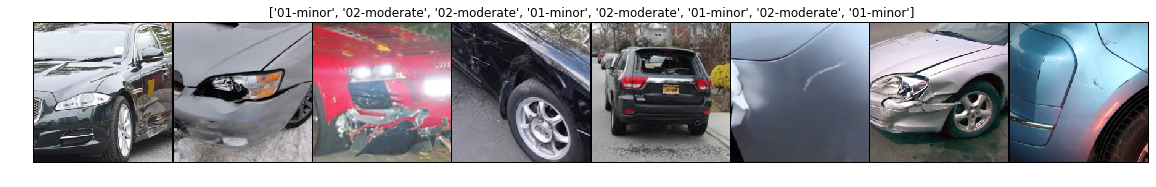

Prediction:


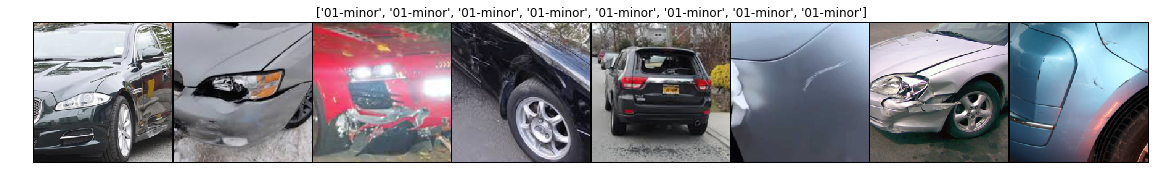

In [13]:
visualize_model(resnet50)